# Rice Leaf Disease Detection

## Introduction
- Rice is a crop that is majorly produced in India and the negative impacts of lead diseases on its production is significant.
- The objective of this project is to develop a model which can successfully classify three diseases that attack rice plant: Bacterial leaf blight, Brown spot, and Leaf smut.
- A Convolutional Neural Network(CNN) Model will be created to complete this task.
- Transfer Learning will also be done with 3 pre-trained models.

#### Project Code: PRCP-1001-RiceLeaf

## Import Libraries and Install Dependencies

In [ ]:
%pip install split-folders

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, BatchNormalization
from keras.utils import plot_model
from keras.utils import load_img, img_to_array, to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import splitfolders
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis

In [ ]:
# split data into train, validation and test
import splitfolders
splitfolders.ratio(
    input=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\Data",
    output="split_data",
    seed=1337,
    ratio=(.8, .1, .1),
    group_prefix=None,
    move=False)

In [ ]:
# assign variables to filepaths
train_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_data\train"
val_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_data\val"
test_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_data\test"

# store label names in a variable
labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [ ]:
# get and display the number of images per class
for i in labels:
  train_dir_images=os.listdir(train_dir+'/'+i)
  val_dir_images=os.listdir(val_dir+'/'+i)
  test_dir_images=os.listdir(test_dir+'/'+i)
  print(f'Number of {i} images: {len(train_dir_images) + len(val_dir_images) + len(test_dir_images)}')
  print()


Number of Bacterial leaf blight images: 40

Number of Brown spot images: 40

Number of Leaf smut images: 39



In [ ]:
# get the class, height and width for each image
disease_type=[]
img_heights=[]
img_widths=[]

for i in [train_dir, val_dir, test_dir]:
    for j in labels:
      image_names=os.listdir(i+'/'+j)
      for k in image_names:
        disease_type.append(j)
        img = Image.open(i+'/'+j+'/'+k)
        width,height = img.size
        img_widths.append(width)
        img_heights.append(height)

In [ ]:
# store data into a pandas dataframe
leaf_df=pd.DataFrame({
    'disease':disease_type,
    'height':img_heights,
    'width':img_widths
})

leaf_df.head()

disease  height  width
0  Bacterial leaf blight     897   3081
1  Bacterial leaf blight     897   3081
2  Bacterial leaf blight     897   3081
3  Bacterial leaf blight     897   3081
4  Bacterial leaf blight     897   3081

In [ ]:
# display summary statistics for the images
leaf_df.describe()

height        width
count  119.000000   119.000000
mean   707.739496  2383.638655
std    311.657582  1123.528972
min     71.000000   250.000000
25%    377.000000  1074.000000
50%    897.000000  3081.000000
75%    897.000000  3081.000000
max    900.000000  3081.000000

### Display Images of Each Class

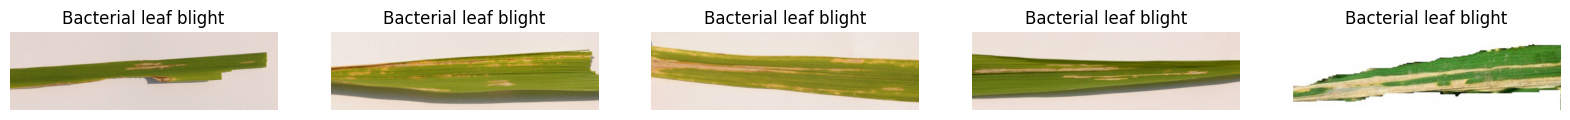

In [ ]:
# display 5 images of the Bacterial leaf blight class
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

for i in range(5):
  plt.subplot(1,5,i+1)
  image_names=os.listdir(train_dir+'/'+labels[0])
  filename = train_dir+'/'+labels[0]+'/'+image_names[i]
  plt.imshow(imread(filename))
  plt.title(labels[0])
  plt.axis('off')

plt.show()

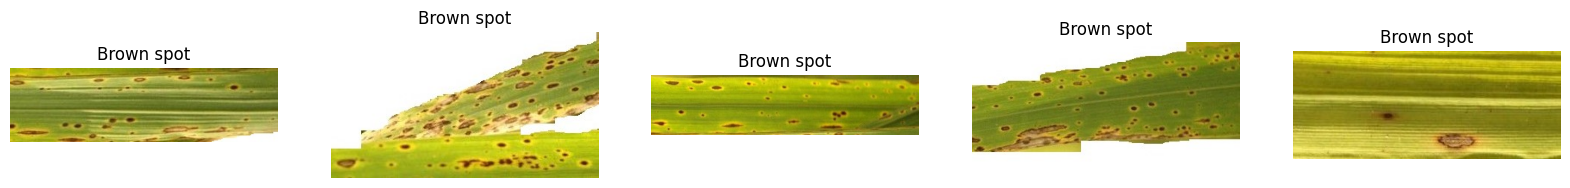

In [ ]:
# display 5 images of the Brown spot class
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

for i in range(5):
  plt.subplot(1,5,i+1)
  image_names=os.listdir(train_dir+'/'+labels[1])
  filename = train_dir+'/'+labels[1]+'/'+image_names[i]
  plt.imshow(imread(filename))
  plt.title(labels[1])
  plt.axis('off')

plt.show()

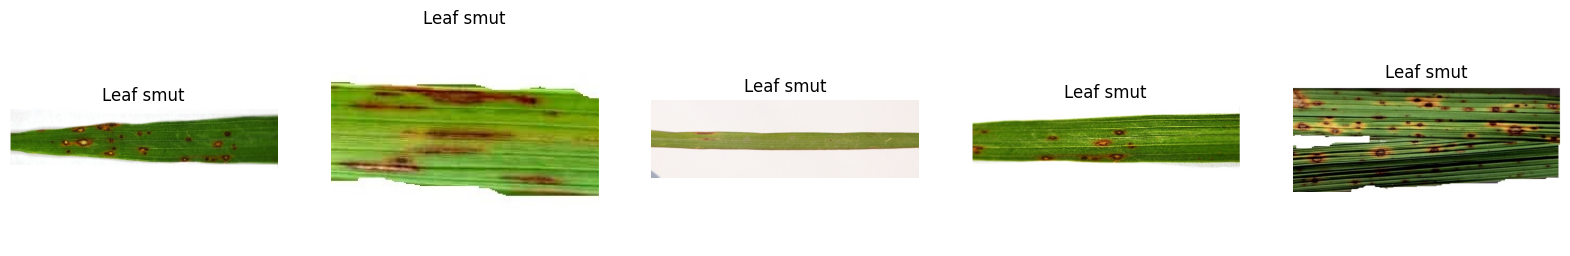

In [ ]:
# display 5 images of the Leaf smut class
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

for i in range(5):
  plt.subplot(1,5,i+1)
  image_names=os.listdir(train_dir+'/'+labels[2])
  filename = train_dir+'/'+labels[2]+'/'+image_names[i]
  plt.imshow(imread(filename))
  plt.title(labels[2])
  plt.axis('off')

plt.show()

### Insights from Analysis

- There are a total of 119 images in the given dataset:
  - 40 Bacterial leaf blight images
  - 40 Brown spot images
  - 39 Leaf smut images
- The minimum height and width from the images are 71 pixels and 250 pixels respectively.
-  The maximum height and width from the images are 900 pixels and 3081 pixels respectively.
- The average height and width from the images are approximately 708 pixels and 2384 pixels respectively.

## Data Preparation

In [ ]:
# CNN model parameters
image_size=224
num_channels=3
batch_size=32

### Data Augmentation

- Since a dataset of 119 images is too small for training the models, we shall use the ImageDataGenerator to generate new augmented images from the given dataset of images.

In [ ]:
img_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

# file path to unprocessed data
data_path = r'C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\Data'
# file path to save new augmented data
save_path = r'C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\DataAug'

# loop through all the images and generate and save augmented images
for i in range(len(labels)):
  image_names=os.listdir(data_path+'/'+labels[i])
  for j in range(len(image_names)):
    img_path = data_path+'/'+labels[i]+'/'+image_names[j]
    img = load_img(img_path, target_size=(image_size, image_size))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    k=0
    for batch in img_datagen.flow(x, batch_size=1, save_to_dir=save_path+'/'+labels[i]+'/',
                                  save_prefix=image_names[j].split('.')[0], save_format='jpg'):
      k += 1
      if i == 2:
        if k == 128:
          break
      else:
        if k == 125:
          break

print('Augmented Images Save Complete.')

Augmented Images Save Complete.


In [ ]:
# split augmented data into train, validation and test sets
import splitfolders
splitfolders.ratio(
    input=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\DataAug",
    output="split_aug_data",
    seed=1337,
    ratio=(.8, .1, .1),
    group_prefix=None,
    move=False)

In [ ]:
# assign variables to filepaths
train_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_aug_data\train"
val_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_aug_data\val"
test_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_aug_data\test"

# store label names in a variable
labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [ ]:
# get and display the total number of images and the number of images per class
num_total=0
for i in labels:
  train_dir_images=os.listdir(train_dir+'/'+i)
  val_dir_images=os.listdir(val_dir+'/'+i)
  test_dir_images=os.listdir(test_dir+'/'+i)
  num_total+=len(train_dir_images) + len(val_dir_images) + len(test_dir_images)
  print(f'Number of {i} images: {len(train_dir_images) + len(val_dir_images) + len(test_dir_images)}')
  print()
print(f'Total Number of images in the dataset: {num_total}')

Number of Bacterial leaf blight images: 4969

Number of Brown spot images: 4962

Number of Leaf smut images: 4955

Total Number of images in the dataset: 14886


#### Augmented Dataset
- In the new augmented dataset of images the distribution of images is:
  - Bacterial leaf blight images: 4969
  - Brown spot images: 4962
  - Leaf smut images: 4955
- The total number of images in the dataset is 14886, which should be sufficient for training the CNN models.
- The number of images in each is fairly the same, so the dataset is balanced.
- Now the data generators are created for the train, validation and test sets for training and testing the models.

In [ ]:
# ImageDataGenerator to generate batches of data for training, validation and testing datasets
# data augmentation is used for generating the training data
# images are rescaled so values are between [0-1] range
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 11908 images belonging to 3 classes.
Found 1487 images belonging to 3 classes.
Found 1491 images belonging to 3 classes.


## CNN Model Development

In [ ]:
# create the CNN model with the following architecture
cnn_model=Sequential()

# input layer
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(image_size, image_size, num_channels)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.4))

# convolutional layer block 1
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.4))

# convolutional layer block 2
cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.4))

# convolutional layer block 3
cnn_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.4))

# fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(1024,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.4))

# output layer
cnn_model.add(Dense(3, activation ='softmax'))

In [ ]:
# # get the summary of the CNN
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

In [ ]:
# configure the model for training
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# callback to get the best model
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

In [ ]:
# training the model with train data and validation with validation data
history=cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping_callback],
)

Epoch 1/10
373/373 [==============================] - 244s 609ms/step - loss: 0.7209 - accuracy: 0.7628 - val_loss: 3.1637 - val_accuracy: 0.4297
Epoch 2/10
373/373 [==============================] - 214s 573ms/step - loss: 0.2222 - accuracy: 0.9222 - val_loss: 1.3658 - val_accuracy: 0.6987
Epoch 3/10
373/373 [==============================] - 213s 568ms/step - loss: 0.1391 - accuracy: 0.9546 - val_loss: 3.9427 - val_accuracy: 0.5387
Epoch 4/10
373/373 [==============================] - 146s 389ms/step - loss: 0.1060 - accuracy: 0.9656 - val_loss: 8.9329 - val_accuracy: 0.4486
Epoch 5/10
373/373 [==============================] - 73s 196ms/step - loss: 0.0792 - accuracy: 0.9742 - val_loss: 0.3859 - val_accuracy: 0.9018
Epoch 6/10
373/373 [==============================] - 76s 202ms/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 0.2004 - val_accuracy: 0.9610
Epoch 7/10
373/373 [==============================] - 74s 199ms/step - loss: 0.0517 - accuracy: 0.9845 - val_loss: 3.5043 - va

In [ ]:
# get the training history of the model
model_history = pd.DataFrame(history.history)

[Text(0.5, 1.0, 'Categorical Crossentropy Loss')]

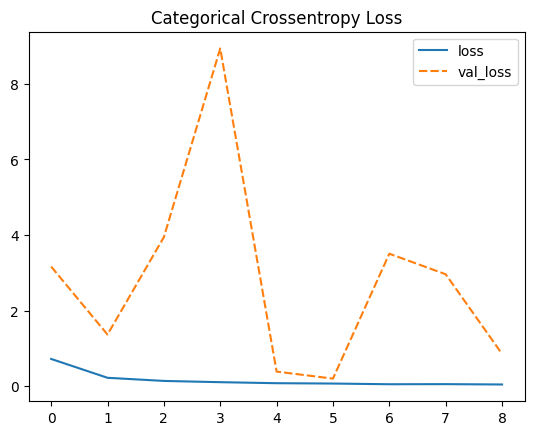

In [ ]:
# plot the training loss vs. val loss
sns.lineplot(data=model_history[['loss', 'val_loss']]).set(title='Categorical Crossentropy Loss')

[Text(0.5, 1.0, 'Classification Accuracy')]

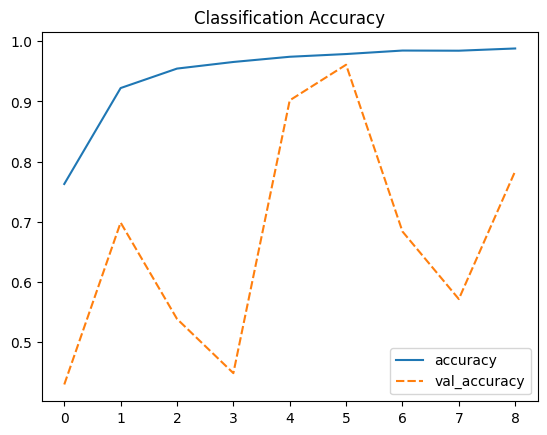

In [ ]:
# plot the training accuracy vs. val accuracy
sns.lineplot(data=model_history[['accuracy', 'val_accuracy']]).set(title='Classification Accuracy')

### Model Evaluation

In [ ]:
# evaluate train data
loss, accuracy = cnn_model.evaluate(train_generator, batch_size=batch_size, verbose=0)
print(f'Model Accuracy for training data: {accuracy*100}')
print(f'Model Loss for training data: {loss}')

print()

# evaluate validation data
loss, accuracy = cnn_model.evaluate(val_generator, batch_size=batch_size, verbose=0)
print(f'Model Accuracy for validation data: {accuracy*100}')
print(f'Model Loss for validation data: {loss}')

print()

test_generator.reset()

# evaluate test data
loss, accuracy = cnn_model.evaluate(test_generator, batch_size=batch_size, verbose=0)

print(f'Model Accuracy for test data: {accuracy*100}')
print(f'Model Loss for test data: {loss}')

Model Accuracy for training data: 94.75982785224915
Model Loss for training data: 0.2431262731552124

Model Accuracy for validation data: 96.09953165054321
Model Loss for validation data: 0.20037122070789337

Model Accuracy for test data: 95.50637006759644
Model Loss for test data: 0.23230573534965515


### Test Images with Predicted and True Labels

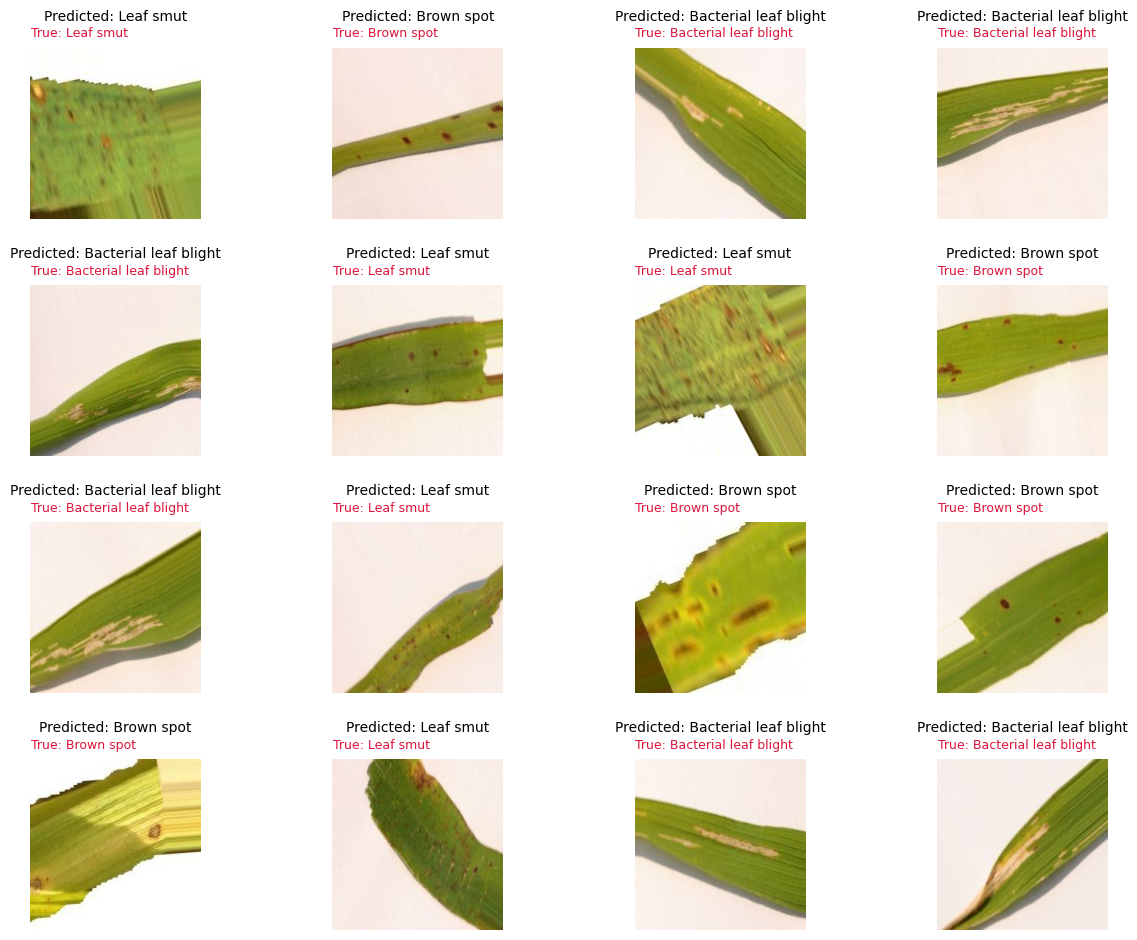

In [ ]:
test_generator.reset()

# get test data images and display the prediction and true labels with the images
images, img_labels = test_generator.next()
fig=plt.figure(figsize=(14,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    test_img = np.expand_dims(images[i], axis=0)
    prediction = cnn_model.predict(test_img, verbose=0)
    pred_idx = np.argmax(prediction, axis=1)[0]
    true_idx = np.argmax(img_labels[i])
    plt.title(f'Predicted: {labels[pred_idx]}', fontsize=10, pad=20)
    plt.text(0, -20, f'True: {labels[true_idx]}', size=9, verticalalignment='center', color='crimson')
    plt.imshow(images[i])
    plt.tight_layout(pad=2)
    plt.axis('off')

## Transfer Learning Models

- We shall try using transfer learning with pre-trained models to see if results are better than the CNN model trained from scratch.

In [ ]:
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import EfficientNetB0
from keras.applications.inception_v3 import InceptionV3
from keras.applications import Xception

In [ ]:
# common parameters for all models
image_size=224
num_channels=3
batch_size=32

In [ ]:
# assign variables to filepaths
train_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_aug_data\train"
val_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_aug_data\val"
test_dir=r"C:\Users\jishn\Datamites\PRCP-1001-RiceLeaf\split_aug_data\test"

# store label names in a variable
labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [ ]:
# helper function to plot accuracy
def plot_accuracy(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

# helper function to plot loss
def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### EfficientNetB0 Model

In [ ]:
# ImageDataGenerator for EfficientNet does not rescale images, model expects pixels with values in the [0-255] range
train_datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 11908 images belonging to 3 classes.
Found 1487 images belonging to 3 classes.
Found 1491 images belonging to 3 classes.


In [ ]:
# create the base pre-trained model
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(image_size, image_size, 3),
    weights="imagenet",
    pooling='avg'
)

x = base_model.output
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add dropout layer
x = Dropout(0.5)(x)
# add a logistic layer for 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
effnet_model = Model(inputs=base_model.input, outputs=predictions)

# freeze all base layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
effnet_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 10s 1us/step


In [ ]:
effnet_hist = effnet_model.fit(train_generator, epochs=4, validation_data=val_generator)

Epoch 1/4
373/373 [==============================] - 79s 202ms/step - loss: 0.1095 - accuracy: 0.9615 - val_loss: 8.0661e-04 - val_accuracy: 1.0000
Epoch 2/4
373/373 [==============================] - 74s 198ms/step - loss: 0.0406 - accuracy: 0.9880 - val_loss: 7.7423e-04 - val_accuracy: 1.0000
Epoch 3/4
373/373 [==============================] - 73s 197ms/step - loss: 0.0289 - accuracy: 0.9919 - val_loss: 2.1066e-05 - val_accuracy: 1.0000
Epoch 4/4
373/373 [==============================] - 72s 194ms/step - loss: 0.0248 - accuracy: 0.9933 - val_loss: 0.0036 - val_accuracy: 0.9987


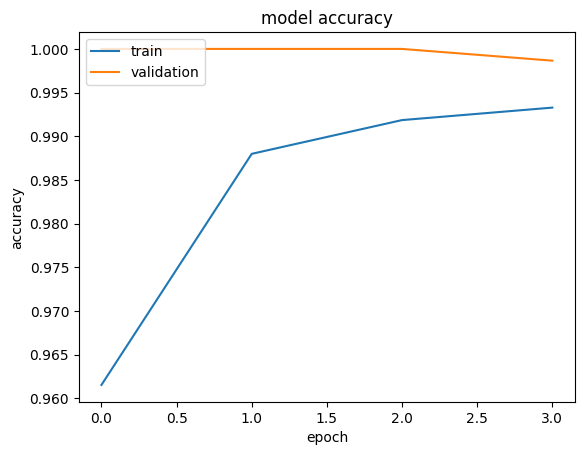

In [ ]:
plot_accuracy(effnet_hist)

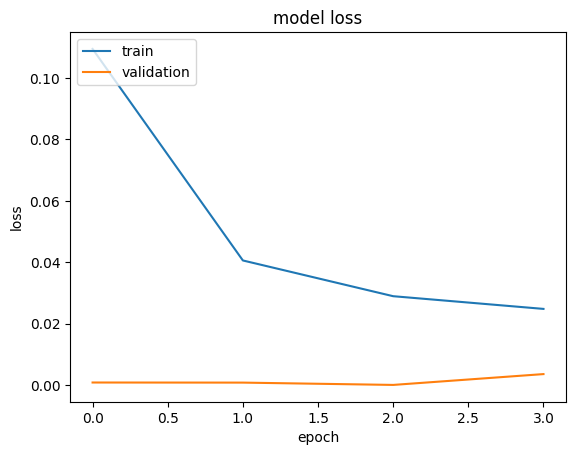

In [ ]:
plot_loss(effnet_hist)

#### EfficientNetB0 Model Evaluation

In [ ]:
# evaluate train data
loss, accuracy = effnet_model.evaluate(train_generator, batch_size=batch_size, verbose=0)
print(f'Model Accuracy for training data: {accuracy*100}')
print(f'Model Loss for training data: {loss}')

print()

# evaluate validation data
loss, accuracy = effnet_model.evaluate(val_generator, batch_size=batch_size, verbose=0)
print(f'Model Accuracy for validation data: {accuracy*100}')
print(f'Model Loss for validation data: {loss}')

print()

test_generator.reset()

# evaluate test data
loss, accuracy = effnet_model.evaluate(test_generator, batch_size=batch_size, verbose=0)

print(f'Model Accuracy for test data: {accuracy*100}')
print(f'Model Loss for test data: {loss}')

Model Accuracy for training data: 99.3533730506897
Model Loss for training data: 0.03024011291563511

Model Accuracy for validation data: 99.86550211906433
Model Loss for validation data: 0.0035502142272889614

Model Accuracy for test data: 99.93293285369873
Model Loss for test data: 0.0007201966363936663


#### Test Images with Predicted and True Labels

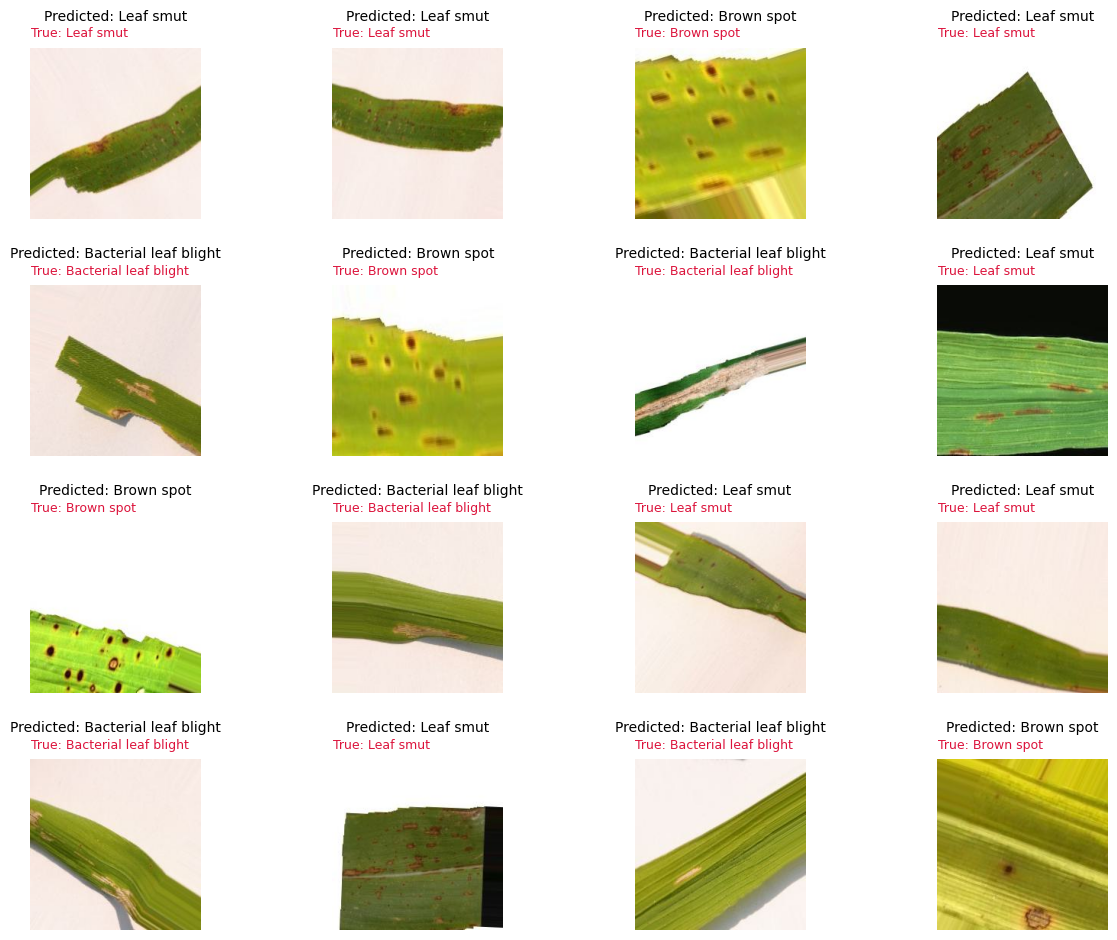

In [ ]:
test_generator.reset()

# get test data images and display the prediction and true labels with the images
images, img_labels = test_generator.next()
fig=plt.figure(figsize=(14,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    test_img = np.expand_dims(images[i], axis=0)
    prediction = effnet_model.predict(test_img, verbose=0)
    pred_idx = np.argmax(prediction, axis=1)[0]
    true_idx = np.argmax(img_labels[i])
    plt.title(f'Predicted: {labels[pred_idx]}', fontsize=10, pad=20)
    plt.text(0, -20, f'True: {labels[true_idx]}', size=9, verticalalignment='center', color='crimson')
    plt.imshow((images[i]).astype(np.uint8))
    plt.tight_layout(pad=2)
    plt.axis('off')

### InceptionV3 Model

In [ ]:
# data generators for InceptionV3 and Xception models
# ImageDataGenerator to generate batches of data for training, validation and testing datasets
# data augmentation is used for generating the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 11908 images belonging to 3 classes.
Found 1487 images belonging to 3 classes.
Found 1491 images belonging to 3 classes.


In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add output layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# final model
incep_model = Model(inputs=base_model.input, outputs=predictions)

# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
incep_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 57s 1us/step


In [ ]:
# train the model on the new data for a few epochs
incep_hist = incep_model.fit(train_generator, epochs=4, validation_data=val_generator)

Epoch 1/4
373/373 [==============================] - 78s 201ms/step - loss: 0.6274 - accuracy: 0.8310 - val_loss: 0.1404 - val_accuracy: 0.9536
Epoch 2/4
373/373 [==============================] - 72s 194ms/step - loss: 0.1678 - accuracy: 0.9419 - val_loss: 0.0224 - val_accuracy: 0.9919
Epoch 3/4
373/373 [==============================] - 75s 202ms/step - loss: 0.1079 - accuracy: 0.9640 - val_loss: 0.0359 - val_accuracy: 0.9879
Epoch 4/4
373/373 [==============================] - 75s 200ms/step - loss: 0.0803 - accuracy: 0.9742 - val_loss: 0.0798 - val_accuracy: 0.9771


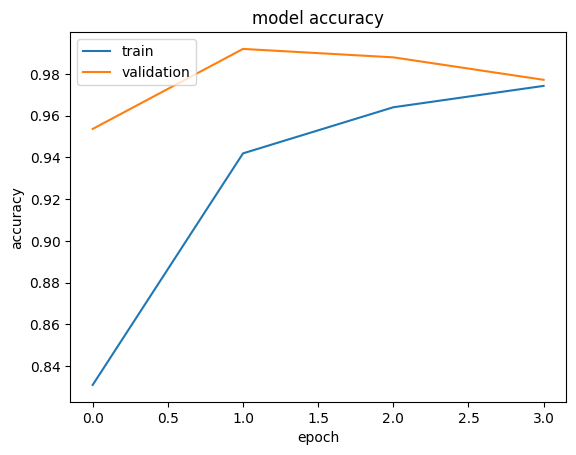

In [ ]:
plot_accuracy(incep_hist)

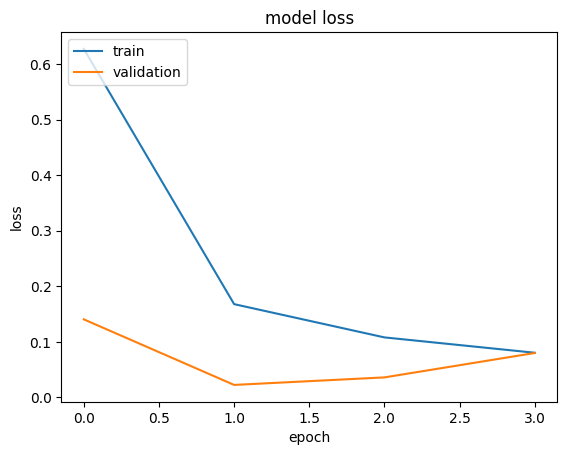

In [ ]:
plot_loss(incep_hist)

#### InceptionV3 Model Evaluation

In [ ]:
# evaluate train data
loss, accuracy = incep_model.evaluate(train_generator, batch_size=batch_size, verbose=0)
print(f'Model Accuracy for training data: {accuracy*100}')
print(f'Model Loss for training data: {loss}')

print()

# evaluate validation data
loss, accuracy = incep_model.evaluate(val_generator, batch_size=batch_size, verbose=0)
print(f'Model Accuracy for validation data: {accuracy*100}')
print(f'Model Loss for validation data: {loss}')

print()

test_generator.reset()

print(f'Model Accuracy for test data: {accuracy*100}')
print(f'Model Loss for test data: {loss}')

print()

Model Accuracy for training data: 94.12999749183655
Model Loss for training data: 0.20585636794567108

Model Accuracy for validation data: 97.7135181427002
Model Loss for validation data: 0.07983774691820145

Model Accuracy for test data: 97.7135181427002
Model Loss for test data: 0.07983774691820145



#### Test Images with Predicted and True Labels

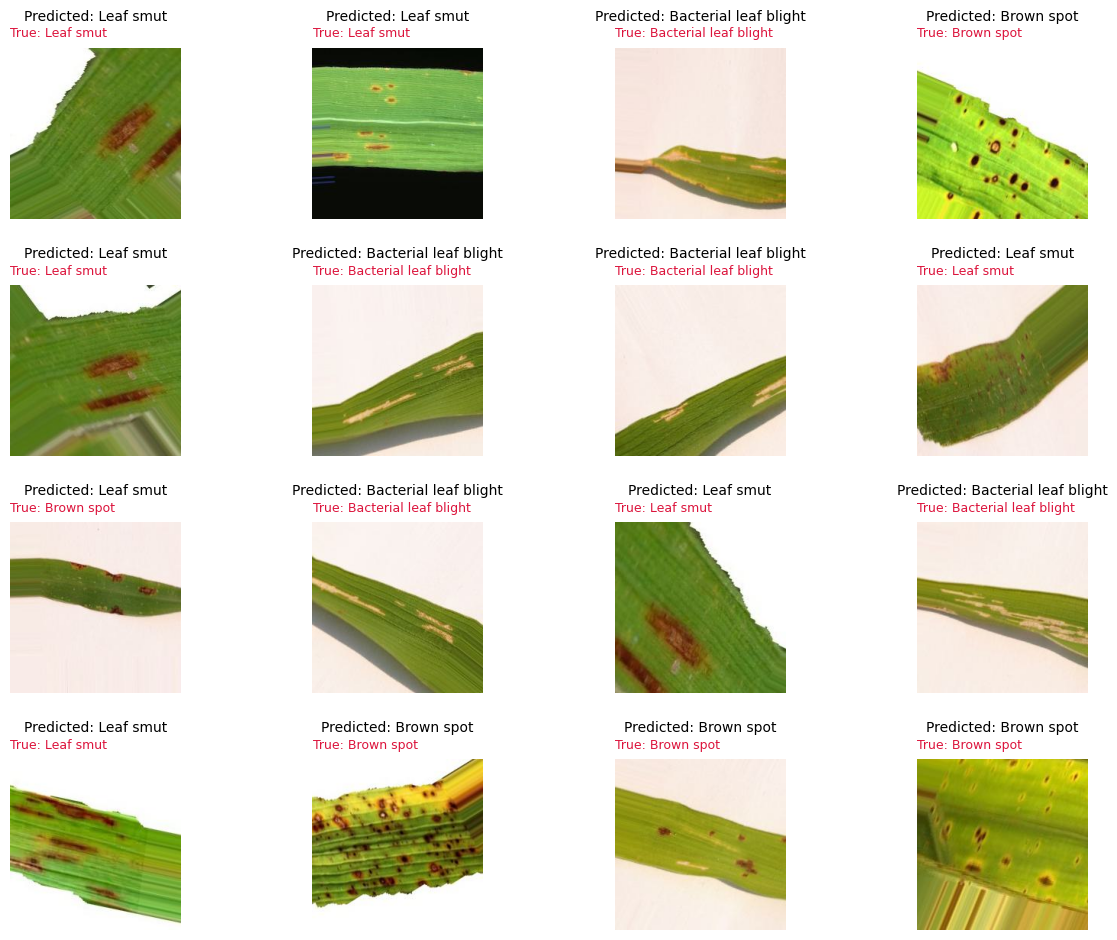

In [ ]:
test_generator.reset()

# get test data images and display the prediction and true labels with the images
images, img_labels = test_generator.next()
fig=plt.figure(figsize=(14,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    test_img = np.expand_dims(images[i], axis=0)
    prediction = incep_model.predict(test_img, verbose=0)
    pred_idx = np.argmax(prediction, axis=1)[0]
    true_idx = np.argmax(img_labels[i])
    plt.title(f'Predicted: {labels[pred_idx]}', fontsize=10, pad=20)
    plt.text(0, -20, f'True: {labels[true_idx]}', size=9, verticalalignment='center', color='crimson')
    plt.imshow(images[i])
    plt.tight_layout(pad=2)
    plt.axis('off')

### Xception Model

In [ ]:
# input data generated for this model is the same as InceptionV3

# create the base pre-trained model
base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, num_channels),
    pooling='avg'
)

x = base_model.output
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add dropout layer
x = Dropout(0.5)(x)
# add a logistic layer for 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
xcep_model = Model(inputs=base_model.input, outputs=predictions)

# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
xcep_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 53s 1us/step


In [ ]:
# train the model on the new data for a few epochs
xcep_hist = xcep_model.fit(train_generator, epochs=4, validation_data=val_generator)

Epoch 1/4
373/373 [==============================] - 78s 202ms/step - loss: 0.3443 - accuracy: 0.8829 - val_loss: 0.0342 - val_accuracy: 0.9859
Epoch 2/4
373/373 [==============================] - 74s 199ms/step - loss: 0.1451 - accuracy: 0.9520 - val_loss: 0.0171 - val_accuracy: 0.9933
Epoch 3/4
373/373 [==============================] - 75s 201ms/step - loss: 0.1142 - accuracy: 0.9646 - val_loss: 0.1083 - val_accuracy: 0.9697
Epoch 4/4
373/373 [==============================] - 77s 206ms/step - loss: 0.1078 - accuracy: 0.9693 - val_loss: 0.0047 - val_accuracy: 0.9987


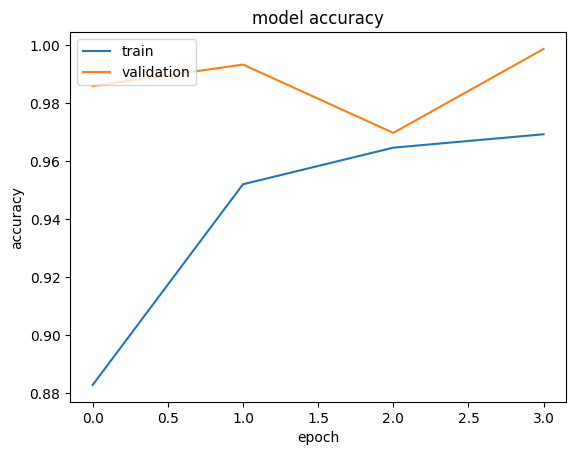

In [ ]:
plot_accuracy(xcep_hist)

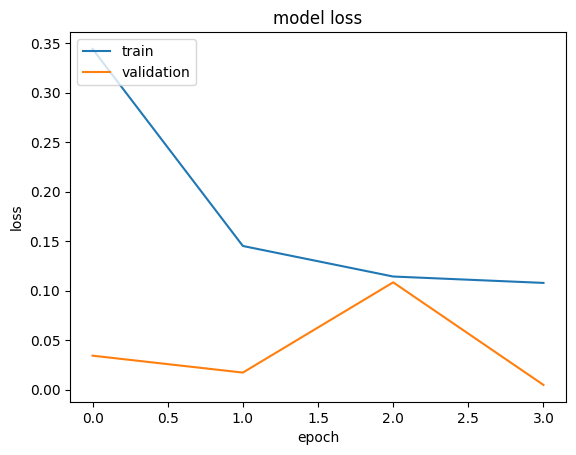

In [ ]:
plot_loss(xcep_hist)

#### Xception Model Evaluation

In [ ]:
# evaluate train data
loss, accuracy = xcep_model.evaluate(train_generator, batch_size=batch_size, verbose=0)
print(f'Model Accuracy for training data: {accuracy*100}')
print(f'Model Loss for training data: {loss}')

print()

# evaluate validation data
loss, accuracy = xcep_model.evaluate(val_generator, batch_size=batch_size, verbose=0)
print(f'Model Accuracy for validation data: {accuracy*100}')
print(f'Model Loss for validation data: {loss}')

print()

test_generator.reset()

# evaluate test data
loss, accuracy = xcep_model.evaluate(test_generator, batch_size=batch_size, verbose=0)

print(f'Model Accuracy for test data: {accuracy*100}')
print(f'Model Loss for test data: {loss}')

Model Accuracy for training data: 98.89150261878967
Model Loss for training data: 0.03319976106286049

Model Accuracy for validation data: 99.86550211906433
Model Loss for validation data: 0.00465470040217042

Model Accuracy for test data: 99.86585974693298
Model Loss for test data: 0.005829766858369112


#### Test Images with Predicted and True Labels

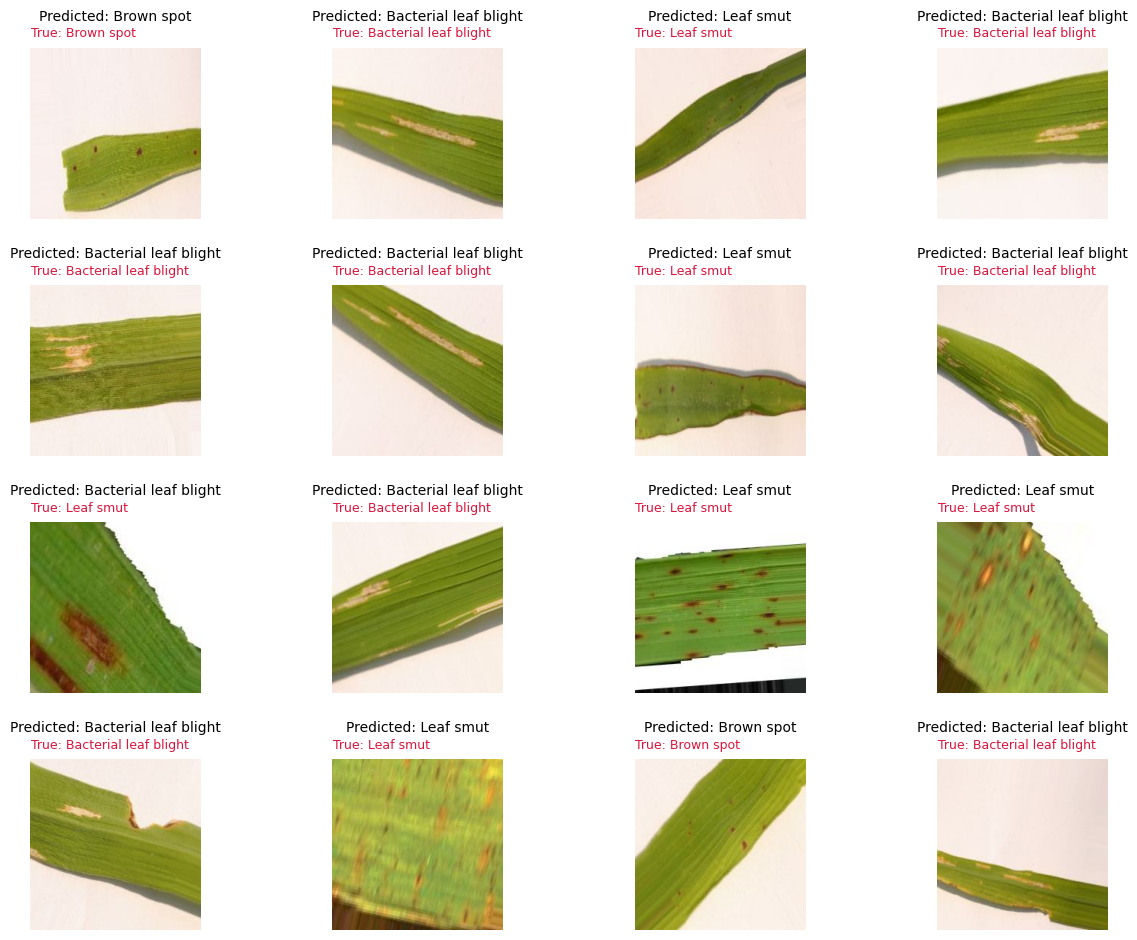

In [ ]:
test_generator.reset()

# get test data images and display the prediction and true labels with the images
images, img_labels = test_generator.next()
fig=plt.figure(figsize=(14,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    test_img = np.expand_dims(images[i], axis=0)
    prediction = xcep_model.predict(test_img, verbose=0)
    pred_idx = np.argmax(prediction, axis=1)[0]
    true_idx = np.argmax(img_labels[i])
    plt.title(f'Predicted: {labels[pred_idx]}', fontsize=10, pad=20)
    plt.text(0, -20, f'True: {labels[true_idx]}', size=9, verticalalignment='center', color='crimson')
    plt.imshow(images[i])
    plt.tight_layout(pad=2)
    plt.axis('off')

### Comparison of Models

In [ ]:
import pandas as pd

In [ ]:
# store model metrics in a dataframe
model_comp_df = pd.DataFrame({
    'Model Name': ['CNN Model from Scratch', 'EfficientNetB0', 'InceptionV3', 'Xception'],
    'Train Accuracy Percentage': [94.7598, 99.3533, 94.1299, 98.8915],
    'Train Loss': [0.2431, 0.0302, 0.2058, 0.0331],
    'Validation Accuracy Percentage': [96.0995, 99.8655, 97.7135, 99.8655],
    'Validation Loss': [0.2003, 0.0035, 0.0798, 0.0046],
    'Test Accuracy Percentage': [95.5063, 99.9329, 97.7135, 99.8658],
    'Test Loss': [0.2323, 0.0007, 0.0798, 0.0058],
})

In [ ]:
model_comp_df

Model Name  Train Accuracy Percentage  Train Loss  \
0  CNN Model from Scratch                    94.7598      0.2431   
1          EfficientNetB0                    99.3533      0.0302   
2             InceptionV3                    94.1299      0.2058   
3                Xception                    98.8915      0.0331   

   Validation Accuracy Percentage  Validation Loss  Test Accuracy Percentage  \
0                         96.0995           0.2003                   95.5063   
1                         99.8655           0.0035                   99.9329   
2                         97.7135           0.0798                   97.7135   
3                         99.8655           0.0046                   99.8658   

   Test Loss  
0     0.2323  
1     0.0007  
2     0.0798  
3     0.0058

---